In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Functions.DecisionTree as tree
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import sys
from typing import Callable
import torch

# Считывание

In [30]:
def draw_classification(df: pd.DataFrame) -> None:
    colours = np.vectorize(lambda classification: -1 if classification == 'P' else 1)(df.loc[:, ['class']])
    plt.scatter(df.loc[:, ['x']], df.loc[:, ['y']], c=colours, cmap='Wistia')
    plt.show()

## Chips

In [31]:
chips = pd.read_csv('chips.csv')
chips

,x,y,class
0,0.051267,0.699560,P
1,-0.092742,0.684940,P
2,-0.213710,0.692250,P
3,-0.375000,0.502190,P
4,-0.513250,0.465640,P
...,...,...,...
113,-0.720620,0.538740,N
114,-0.593890,0.494880,N
115,-0.484450,0.999270,N
116,-0.006336,0.999270,N


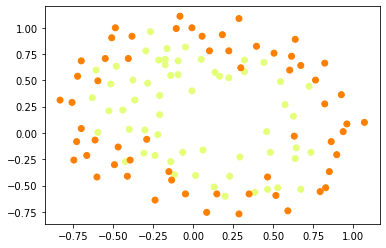

In [32]:
draw_classification(chips)

In [33]:
chips['class'] = np.vectorize(lambda classification: 0 if classification == 'P' else 1)(
    chips.loc[:, ['class']]).reshape(-1, ).astype(int)
chips

,x,y,class
0,0.051267,0.699560,0
1,-0.092742,0.684940,0
2,-0.213710,0.692250,0
3,-0.375000,0.502190,0
4,-0.513250,0.465640,0
...,...,...,...
113,-0.720620,0.538740,1
114,-0.593890,0.494880,1
115,-0.484450,0.999270,1
116,-0.006336,0.999270,1


## Gaysers

In [34]:
geysers = pd.read_csv('geyser.csv')
geysers

,x,y,class
0,1,4.4,N
1,1,3.9,N
2,1,4.0,P
3,1,4.0,N
4,1,3.5,N
...,...,...,...
217,23,2.1,P
218,23,4.2,N
219,23,2.1,P
220,23,5.2,N


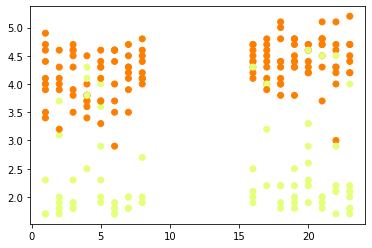

In [35]:
draw_classification(geysers)

In [36]:
geysers['class'] = np.vectorize(lambda classification: 0 if classification == 'P' else 1)(
    geysers.loc[:, ['class']]).reshape(-1, ).astype(int)
geysers

,x,y,class
0,1,4.4,1
1,1,3.9,1
2,1,4.0,0
3,1,4.0,1
4,1,3.5,1
...,...,...,...
217,23,2.1,0
218,23,4.2,1
219,23,2.1,0
220,23,5.2,1


# Нормируем

In [37]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [38]:
data = scaler.fit_transform(chips.drop(columns=['class']))
chips['x'] = data[:, 0]
chips['y'] = data[:, 1]
chips

,x,y,class
0,0.463625,0.782108,0
1,0.387869,0.774326,0
2,0.324234,0.778217,0
3,0.239388,0.677048,0
4,0.166662,0.657593,0
...,...,...,...
113,0.057576,0.696504,1
114,0.124242,0.673157,1
115,0.181812,0.941644,1
116,0.433323,0.941644,1


# Отрисовка

In [39]:
def make_meshgrid(x: np.ndarray, y: np.ndarray, steps=100):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    steps: number of steps for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """

    x_min, x_max = np.min(x) - 1, np.max(x) + 1
    y_min, y_max = np.min(y) - 1, np.max(y) + 1
    h_x = (x_max - x_min) / steps
    h_y = (y_max - y_min) / steps
    if pd.api.types.is_int64_dtype(x):
        return np.meshgrid(x, np.arange(y_min, y_max, h_y))
    else:
        return np.meshgrid(np.arange(x_min, x_max, h_x), np.arange(y_min, y_max, h_y))


def plot_contours(ax, model: Callable[[pd.Series], int], xx: np.ndarray, yy: np.ndarray, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    model: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    prediction = [[model(pd.Series(data={'x': xx[i][j], 'y': yy[i][j]})) for j in range(xx.shape[1])] for i in
                  range(xx.shape[0])]
    out = ax.contourf(xx, yy, prediction, **params)
    return out

# Выбираем лучшее дерево

In [40]:
def best(data: pd.DataFrame, name: str):
    depths = np.concatenate([np.arange(start=3, stop=20, step=2), [sys.maxsize]])
    trees = {'entropy': lambda data, depth, enable: tree.EntropyDecisionTree(data, depth=depth, enable_random=enable),
             'gini': lambda data, depth, enable: tree.GiniGainDecisionTree(data, depth=depth, enable_random=enable)}
    models = ['entropy', 'gini']
    enable_random = [True, False]

    best_depth = 5
    best_model = 'entropy'
    best_accuracy = 0

    for current_depth in depths:
        for model in models:
            for enable in enable_random:
                k_fold = KFold(n_splits=10, shuffle=True)
                accuracies = []
                for train_index, test_index in k_fold.split(data):
                    decision_tree = trees[model](data.iloc[train_index], current_depth, enable)
                    expected = data.loc[test_index]['class'].to_numpy()
                    test = data.loc[test_index].drop(columns=['class'])
                    actual = [decision_tree.predict(test.loc[index]) for index in test_index]
                    accuracies.append(accuracy_score(y_true=expected, y_pred=actual))
                accuracy = np.mean(accuracies)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_model = model
                    best_depth = current_depth

    print(f'Лучшая модель для {name} - {best_model} с глубиной = {best_depth}. Значение accuracy = {best_accuracy}')

    gini_decision_forest = tree.RandomForest(data=data, model='gini')
    forests = [tree.RandomForest(data=data, model='entropy'), gini_decision_forest]
    titles = [f'Entropy лес для {name}', f'Gini лес для {name}']
    fig, sub = plt.subplots(2, 1, figsize=(15, 20))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    features_x, features_y = data['x'].to_numpy(), data['y'].to_numpy()
    xx, yy = make_meshgrid(features_x, features_y)
    for forest, title, ax in zip(forests, titles, sub.flatten()):
        plot_contours(ax, forest.predict, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(features_x, features_y, c=data['class'].to_numpy(), cmap=plt.cm.coolwarm, s=20, edgecolors="k")
        ax.set_xlim(np.min(xx), np.max(xx))
        ax.set_ylim(np.min(yy), np.max(yy))
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)

    plt.show()

In [41]:
def predict_ada(trees: list[tree.DecisionTree], alphas: list[float], series: pd.Series) -> int:
    result = 0
    for i in range(len(trees)):
        prediction = trees[i].predict(series)
        if prediction == 1:
            result += alphas[i]
        else:
            result -= alphas[i]
    return 0 if result <= 0 else 1


def ada_boost(data: pd.DataFrame, name: str):
    t = 55
    stops = [1, 2, 3, 5, 8, 13, 21, 34, 55]
    stop_positions = {1: 0,
                      2: 1,
                      3: 2,
                      5: 3,
                      8: 4,
                      13: 5,
                      21: 6,
                      34: 7,
                      55: 8}
    fig, sub = plt.subplots(len(stops), 1, figsize=(15, 20))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    trees = []
    alphas = []
    accuracies = []
    weights = np.full((data.shape[0],), 1 / data.shape[0])
    for i in range(t):
        ada_tree = tree.EntropyDecisionTree(data=data, weights=weights, depth=3, enable_random=True)
        test = data.drop(columns=['class'])
        n = np.array([0 if data.loc[index]['class'] == ada_tree.predict(test.loc[index]) else 1 for index in
                      data.index.to_numpy()])
        error = np.sum(weights * n)
        alpha = np.log((1 - error) / error) / 2
        weights = weights * np.exp(alpha * n)

        trees.append(ada_tree)
        alphas.append(alpha)
        actual = [predict_ada(trees, alphas, test.loc[index]) for index in data.index.to_numpy()]
        accuracies.append(accuracy_score(y_true=data['class'].to_numpy(), y_pred=actual))
        weights /= np.sum(weights)
        if i + 1 in stops:
            features_x, features_y = data['x'].to_numpy(), data['y'].to_numpy()
            xx, yy = make_meshgrid(features_x, features_y)
            ax = sub.flatten()[stop_positions[i + 1]]
            plot_contours(ax, lambda series: predict_ada(trees, alphas, series), xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
            ax.scatter(features_x, features_y, c=data['class'].to_numpy(), cmap=plt.cm.coolwarm, s=20, edgecolors="k")
            ax.set_xlim(np.min(xx), np.max(xx))
            ax.set_ylim(np.min(yy), np.max(yy))
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_xticks(())
            ax.set_yticks(())
            ax.set_title(f'Ada-boost для {name} итерация {i}')
    plt.show()

    plt.plot(np.arange(start=1, stop=t + 1), accuracies)
    plt.xlabel('Итерация')
    plt.ylabel('Accuracy')
    plt.title('Зависимость accuracy от итерации')
    plt.show()

Лучшая модель для chips - gini с глубиной = 5. Значение accuracy = 0.771969696969697


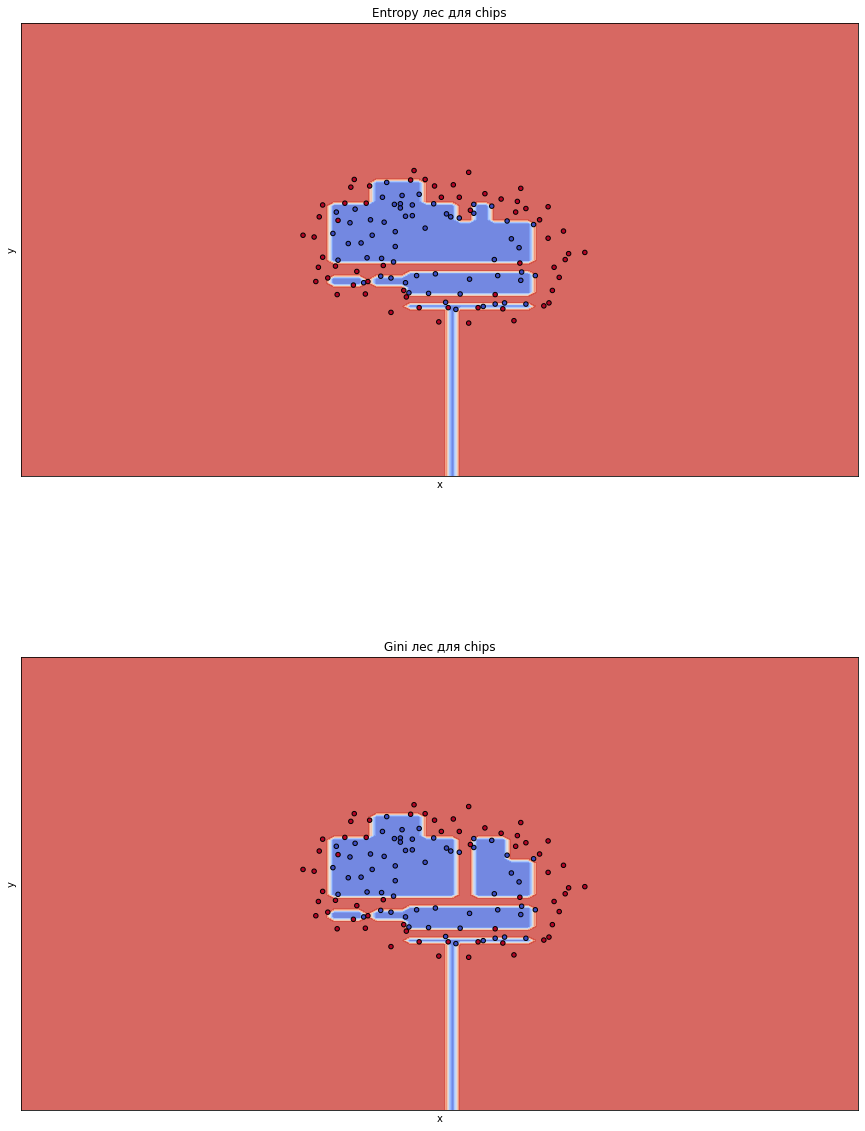

In [42]:
best(chips, 'chips')

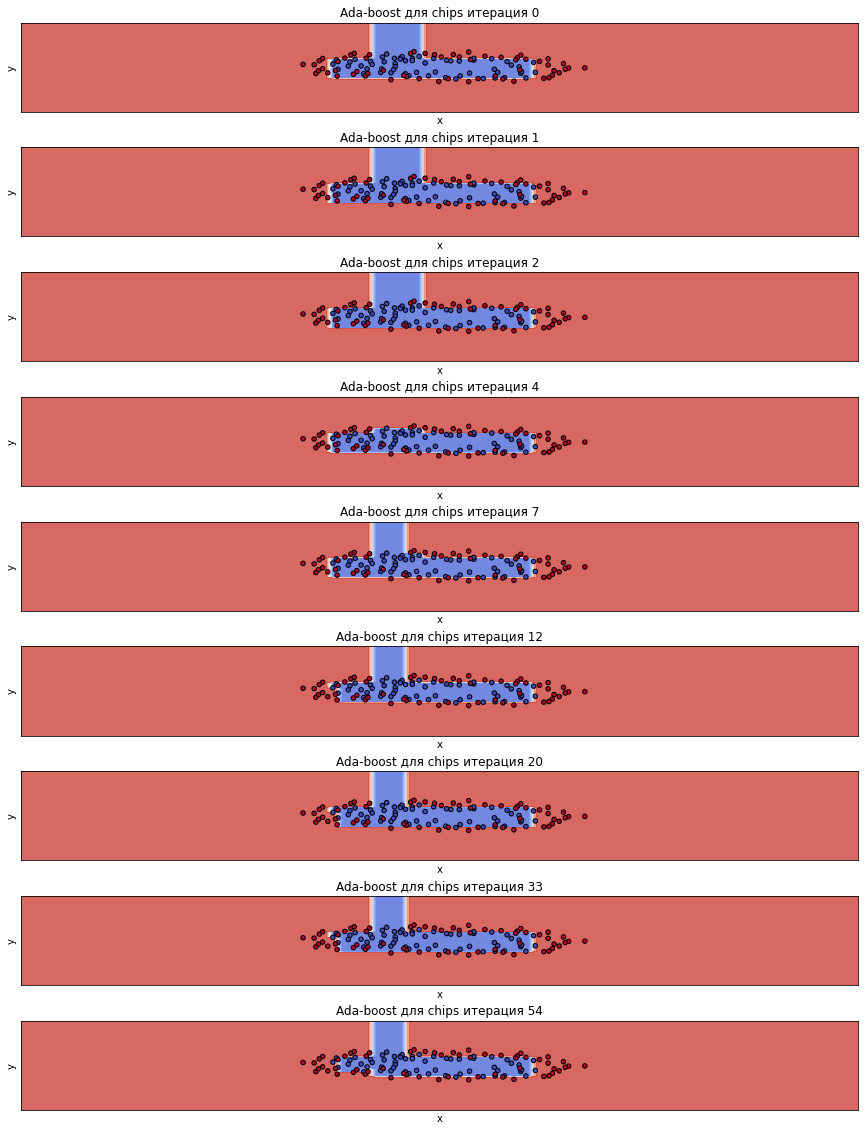

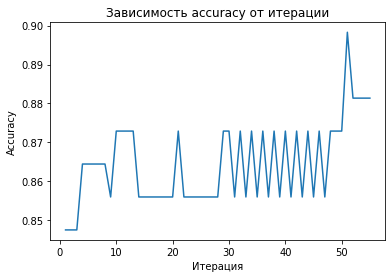

In [43]:
ada_boost(chips, 'chips')

Лучшая модель для geysers - entropy с глубиной = 3. Значение accuracy = 0.8920948616600791


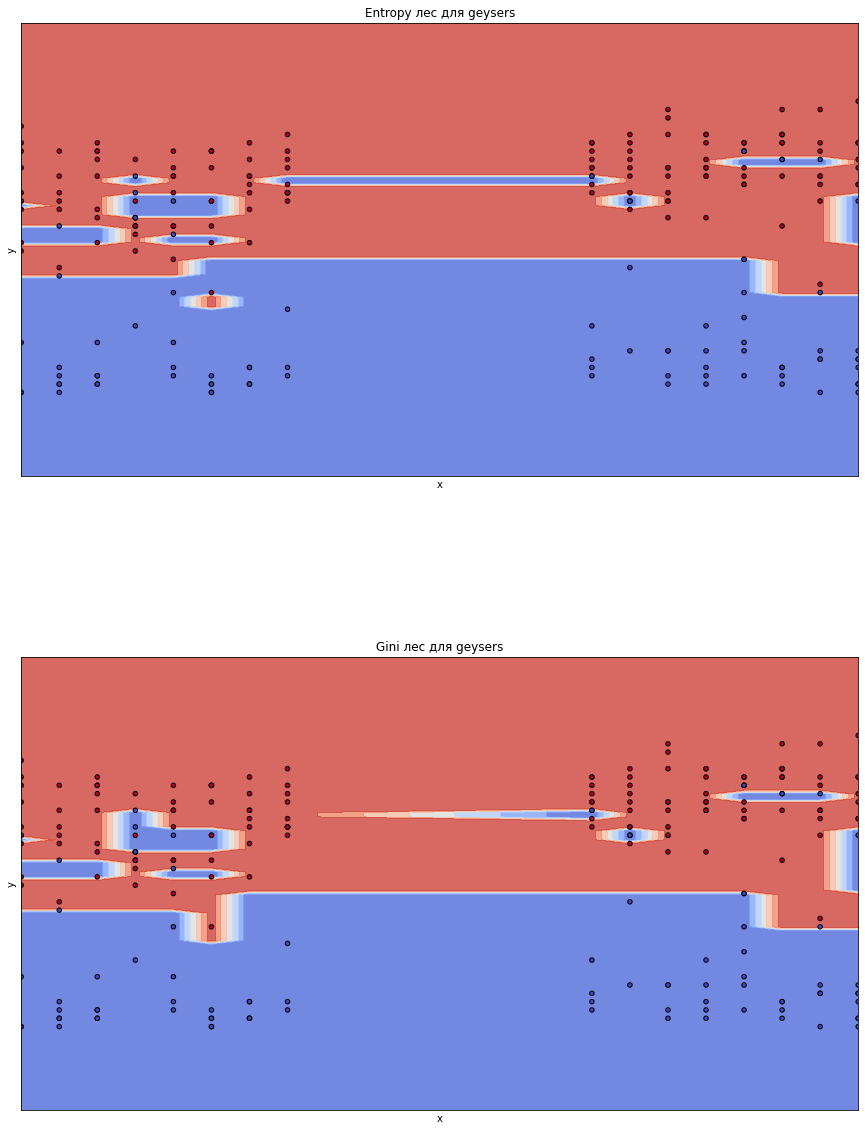

In [44]:
best(geysers, 'geysers')

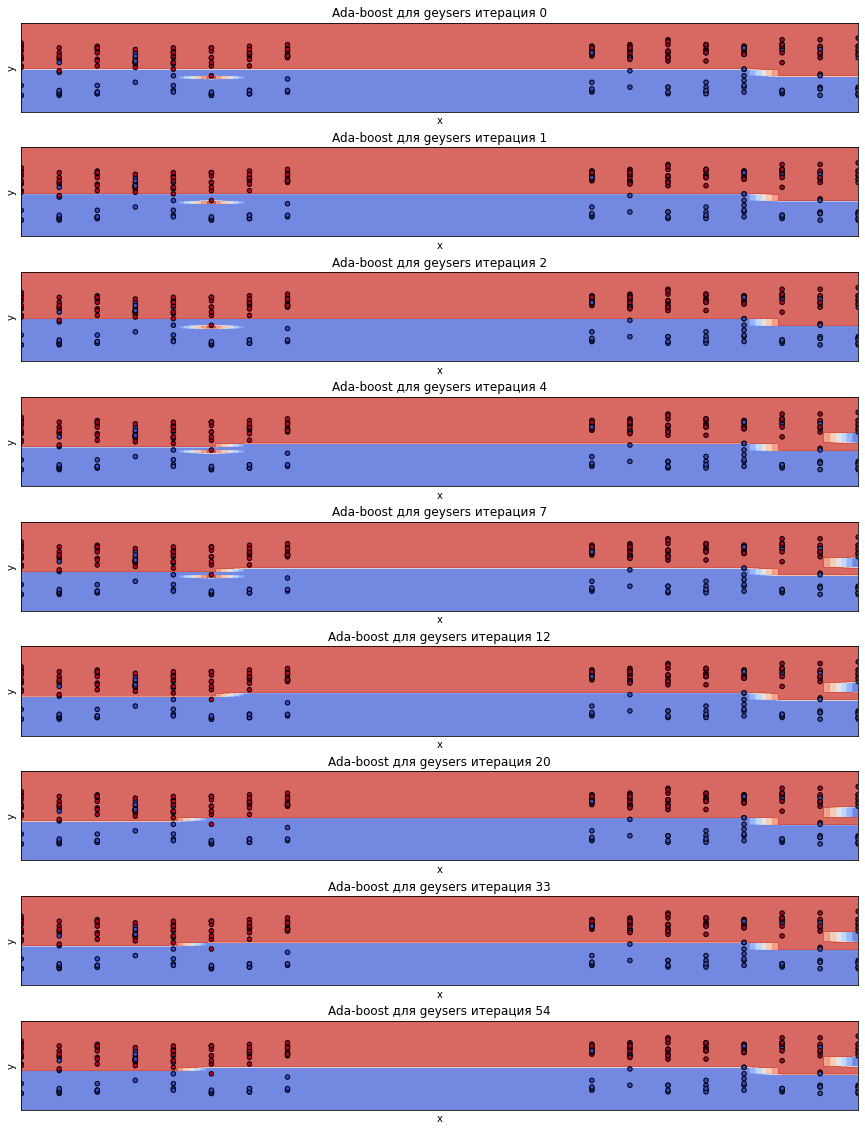

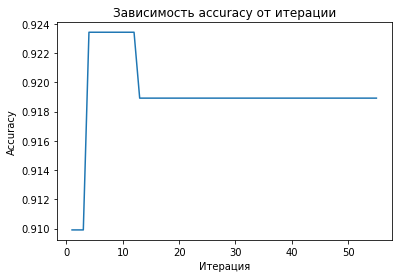

In [45]:
ada_boost(geysers, 'geysers')